### Стартуем

#### Импортируем BigARTM:

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline
import artm
import pandas as pd
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from tqdm import tqdm
import nltk
import re
import numpy as np

### Загружаем наш датасет

In [2]:
df = pd.read_csv('final_dataset.csv')
df = df.dropna()
abstracts_list = df.Abstract.tolist()

In [220]:
df.head()

,Abstract,Author,Date,Journal,Title
0,Recurrent neural networks (RNNs) have been wid...,Yong Yu,2019-06-14,Neural Computation,A Review of Recurrent Neural Networks: LSTM Ce...
1,Epilepsy is a neurological disorder characteri...,Anup Das,2019-06-14,Neural Computation,Characterizing Brain Connectivity From Human E...
2,"This letter proposes a novel method, multi-inp...",Kunling Geng,2019-06-14,Neural Computation,"Multi-Input, Multi-Output Neuronal Mode Networ..."
3,With the development of neural recording techn...,G. Sun,2019-06-14,Neural Computation,Effective Dimensionality Reduction for Visuali...
4,The thalamus has traditionally been considered...,Nima Dehghani,2019-06-14,Neural Computation,A Computational Perspective of the Role of the...


In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5262 entries, 0 to 5642
Data columns (total 5 columns):
Abstract    5262 non-null object
Author      5262 non-null object
Date        5262 non-null object
Journal     5262 non-null object
Title       5262 non-null object
dtypes: object(5)
memory usage: 246.7+ KB


###   В первую очередь нужно лемматизировать и преобразовать все данные в vowpal-wabbit. Это формат с которым работает модель

In [3]:
stop_words = stopwords.words('english') # получим словарь стоп-слов

lemmatizer=WordNetLemmatizer() #лемматизатор из WOrdNet

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def lemmatizer_func(sentence):
    sentence=sentence.replace(',','').replace('.','').replace(')','').replace('(','').replace(':','')
    sentence=sentence.replace(';','').replace('-','')
    return [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(sentence)]

def stop_words_remover(sentence): # удаляет стоп слова
    return [word for word in sentence if word not in stop_words]

def return_cleaned_array(array): # комбинирует наши веhхние функции выдает очищенный массив
    array1 = []
    for i in tqdm(array):
        lemma=lemmatizer_func(i)
        Lemma = [word.lower() for word  in lemma]
        array1.append(stop_words_remover(Lemma))
    #*********************************************
    array2 = []
    for i in tqdm(array1):
        array2.append(str(i).replace(']','').replace('[','').replace("'",'').replace(',',''))
    #*********************************************
    #import re    
    regex = re.compile('[^a-zA-Z]')
    final_array = []
    for i in tqdm(array2):    
        final_array.append(regex.sub(' ', i))
    return final_array

def txt_writer(data,filename): #ЗАПИСЫВАЕТ НАШИ МАССИВЫ В TXT FILE
    #saving collection in txt file
    outF = open(filename, "w")
    for i in tqdm(data):
      # write line to output file
          outF.write(str(i))
          outF.write("\n")
    outF.close()

#### Применим эти функции

In [271]:
title = return_cleaned_array(df.Title.values)

100%|██████████| 5262/5262 [00:00<00:00, 255764.47it/s]


In [273]:
author = return_cleaned_array(df.Author.values)

100%|██████████| 5262/5262 [00:00<00:00, 249228.48it/s]


In [274]:
journal = return_cleaned_array(df.Journal.values)

100%|██████████| 5262/5262 [00:00<00:00, 414771.90it/s]


In [275]:
text = return_cleaned_array(df.Abstract.values)

100%|██████████| 5262/5262 [00:00<00:00, 27449.82it/s]


In [278]:
date = df.Date.values

#### Так выглядят данные после обработки

In [279]:
text[0], author[0], journal[0], title[0], date[0]

('recurrent neural network rnns widely adopt research area concerned sequential data text audio video however rnns consist sigma cell tanh cell unable learn relevant information input data input gap large introduce gate function cell structure long shortterm memory lstm could handle problem longterm dependency well since introduction almost excite result base rnns achieve lstm lstm become focus deep learn review lstm cell variant explore learn capacity lstm cell furthermore lstm network divide two broad category lstmdominated network integrate lstm network addition various application discuss finally future research direction present lstm network',
 'yong yu',
 'neural computation',
 'review recurrent neural networks lstm cells network architectures',
 '2019-06-14')

#### Получим списки формата vowpal wabbit

In [286]:
#data vowpal wabbit format with doc/{1,2,...} + modality
array_with_modality = []
j=0
for q,w,e,r,t in zip(text, title, author, date, journal):
    array_with_modality.append(f'doc_{j}'+' '
                               '|text'+' '+q+' '+
                               '|title'+' '+w+' '+
                               '|author'+' '+e+' '+
                               '|date'+' '+r+' '+
                               '|journal'+' '+t)
    j+=1

In [ ]:
for i in text:    
    final_vw_data.append(f'doc_{j}' + ' ' +'|text'+ ' ' + i)
    j+=1

In [16]:
#deleting digits
#final_abstract = list(map(lambda x: " ".join(x for x in str(x).split() if not x.isdigit()),final_abstract))

#### Получаем в итоге документы в следующем виде(один корпус просто текст, второй с модальностями)

In [287]:
final_vw_data[0], array_with_modality[0]

('doc_0 |text recurrent neural network rnns widely adopt research area concerned sequential data text audio video however rnns consist sigma cell tanh cell unable learn relevant information input data input gap large introduce gate function cell structure long shortterm memory lstm could handle problem longterm dependency well since introduction almost excite result base rnns achieve lstm lstm become focus deep learn review lstm cell variant explore learn capacity lstm cell furthermore lstm network divide two broad category lstmdominated network integrate lstm network addition various application discuss finally future research direction present lstm network',
 'doc_0 |text recurrent neural network rnns widely adopt research area concerned sequential data text audio video however rnns consist sigma cell tanh cell unable learn relevant information input data input gap large introduce gate function cell structure long shortterm memory lstm could handle problem longterm dependency well si

### Запишем наши данные в файл чтобы не перезапукать ячейки много раз

In [291]:
txt_writer(data=array_with_modality, filename="array_with_modality.txt")

100%|██████████| 5262/5262 [00:00<00:00, 181746.84it/s]


In [ ]:
txt_writer(data=final_vw_data,filename="final_vw_data.txt")

#### В этой ячейке создается словарь всех уникальных слов из нашего корпуса, необходимо для того чтобы рассчитывать сoherence, с помощью утилиты(бинарника) bigartm, можно получить так называемый словарь со-взаимности. Output: файлы cooc_tf_, cooc_df_, ppmi_tf_, ppmi_df_ − файлы со-встречаемостей и посчитанные по ним PPMI, результат работы алгоритма.Подробнее https://nbviewer.jupyter.org/github/bigartm/bigartm-book/blob/master/junk/cooc_dictionary/example_of_gathering.ipynb

In [161]:
#creating array with dictionary of unique words from collection 
arr1=[]
for element in final_abstract:    
    arr1.append(regex.sub(' ', element))
arr2=[]
for element in arr1:
    doc = element.split(' ')
    for word in doc:
        arr2.append(word + ' ' + 'text')
slvr  = list(set(arr2))
# сразу запишем в txt
txt_writer(slvr)

### Считывание данных, преобразуем в формат c которым работает модель batch_vectorizer

In [195]:
batch_vectorizer = artm.BatchVectorizer(data_path="final_vw_data.txt", data_format="vowpal_wabbit",
                                        target_folder="final_vw_data")

In [2]:
batch_vectorizer = artm.BatchVectorizer(data_path='final_vw_data',
                                        data_format='batches')

#### Создаем словарь, чтобы в дальнейшем инициализировать модель с его помощью

In [3]:
dictionary = artm.Dictionary()
dictionary.gather(batch_vectorizer.data_path)

#### Создадим словарь со-встречаемостей

In [21]:
cooc_dict = artm.Dictionary()
cooc_dict.gather(
    data_path='final_vw_data',
    cooc_file_path='cooc_tf_.txt',
    vocab_file_path='slvr.txt',
    symmetric_cooc_values=False)

#### Проверим как меняются различные метрики от количества топиков

In [64]:
purity_list = []
contrast_list = []
num_topics_list = []
perplexity_list = []

for i in tqdm(range(2,30,2)):
    #creating topic names and coherence score
    #creating model
    model_artm = artm.ARTM(num_topics=i, 
                       class_ids={"text":1},
                       reuse_theta=True, cache_theta=True, seed=-1)
    #initializing model
    model_artm.initialize(dictionary)
    #adding score to the model
    model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore'))
    model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore',class_id = 'text',
                                                  probability_mass_threshold=0.3))
    
    #fit model                      
    model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=10)
    #scores to list             
    num_topics_list.append(i)
    purity_list.append(np.mean(model_artm.score_tracker['TopicKernelScore'].last_average_purity))
    contrast_list.append(np.mean(model_artm.score_tracker['TopicKernelScore'].last_average_contrast))
    perplexity_list.append(model_artm.score_tracker['PerplexityScore'].last_value)

100%|██████████| 14/14 [01:15<00:00,  6.31s/it]


Text(0, 0.5, 'Purity')

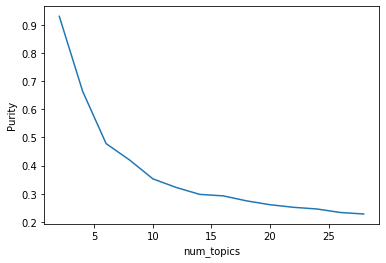

In [75]:
plt.plot(num_topics_list,purity_list)
plt.xlabel("num_topics")
plt.ylabel("Purity")

Text(0, 0.5, 'Contrast')

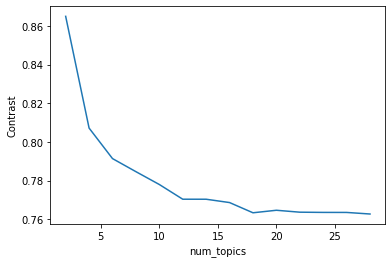

In [76]:
plt.plot(num_topics_list,contrast_list)
plt.xlabel("num_topics")
plt.ylabel("Contrast")

Text(0, 0.5, 'num_topics')

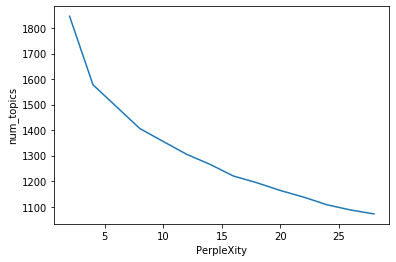

In [67]:
plt.plot(num_topics_list,perplexity_list)
plt.xlabel("PerpleXity")
plt.ylabel("num_topics")

### Создадим модель и инициализируем с помощью словаря

In [68]:
num_topics = 4
#from documentation
model_artm = artm.ARTM(num_topics=num_topics, 
                       class_ids={"text":1},
                       reuse_theta=True, cache_theta=True, seed=-1)

In [69]:
model_artm.initialize(dictionary)

#### В данной ячейке представлены все регулизаторы и метрики

In [70]:
model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore',class_ids={'text':1}))
model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore', class_id='text'))
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore',class_id='text',
                                                  probability_mass_threshold=0.3))
model_artm.scores.add(artm.TopTokensScore(name='TopTokensScore',class_id='text', num_tokens=10))
#model_artm.scores.add(artm.TopTokensScore(
#                            name='TopTokensCoherenceScore',
#                            class_id='text',
#                            num_tokens=10,
#                            dictionary=cooc_dict))
#model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta',tau=-0.15))
#model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1))

#model_artm.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5))

#### Строим модель. Offline - проходит по всей коллекции много раз. Удобно, когда коллекция маленькая.

In [51]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

#### Необходимое число итераций можно отслеживать по графику перплексии. Когда она перестала меняться, модель сошлась.


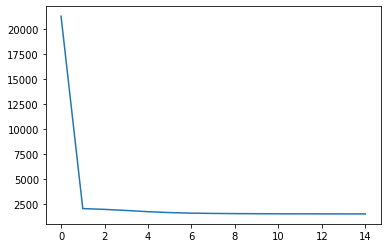

In [41]:
plt.plot(model_artm.score_tracker["PerplexityScore"].value)

#### Выведем наши топики и значения различных scores

In [42]:
for topic_name in model_artm.topic_names:
    print (topic_name + ': ',)
    print (model_artm.score_tracker['TopTokensScore'].last_tokens[topic_name])

topic_0: 
['model', 'algorithm', 'use', 'method', 'data', 'speech', 'propose', 'learn', 'show', 'approach']
topic_1: 
['network', 'neural', 'learn', 'model', 'use', 'show', 'system', 'input', 'representation', 'function']
topic_2: 
['model', 'neuron', 'spike', 'input', 'synaptic', 'time', 'fire', 'show', 'activity', 'network']
topic_3: 
['language', 'model', 'system', 'word', 'use', 'approach', 'corpus', 'task', 'paper', 'information']


In [27]:
def scores():
    print ("SparsityPhiScore : ",model_artm.score_tracker["SparsityPhiScore"].last_value)
    print()
    print ("SparsityThetaScore : ",model_artm.score_tracker["SparsityThetaScore"].last_value)
    print()
    print ("PerplexityScore : ",model_artm.score_tracker["PerplexityScore"].last_value)
    print()
    print ("Size : ",np.mean(model_artm.score_tracker["TopicKernelScore"].average_size))
    print()
    print ("Coherence : ",np.mean(model_artm.score_tracker["TopicKernelScore"].average_coherence))
    print()
    print ("Purity : ",np.mean(model_artm.score_tracker["TopicKernelScore"].average_purity))
    print()
    print ("Contrast : ",np.mean(model_artm.score_tracker["TopicKernelScore"].average_contrast))
    #print (model_artm.score_tracker['TopTokensCoherenceScore'].average_coherence)

In [43]:
scores()

SparsityPhiScore :  0.4424726963043213

SparsityThetaScore :  0.24040289223194122

PerplexityScore :  1557.5989990234375

Size :  6505.866666666667

Coherence :  0.0

Purity :  0.6418361226717632

Contrast :  0.7344791670640309


#### В темах много общеупотребительных слов (так называемой, фоновой лексики). Чтобы этого избежать, будем использовать разреживающий регуляризатор для матрицы фи. Он будет подавлять слова, которые имеют большую частоту во всей коллекции. Выставим tau = -100.

In [71]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-50))
#model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name = 'SparseTheta',tau=-1))
model_artm.regularizers.add(artm.DecorrelatorPhiRegularizer(name = 'DecorellatorPhi', tau = 2.5e+5),overwrite=True)

#### Cнова построим модель

In [72]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

In [73]:
for topic_name in model_artm.topic_names:
    print (topic_name + ': ',)
    print (model_artm.score_tracker['TopTokensScore'].last_tokens[topic_name])

topic_0: 
['use', 'method', 'data', 'algorithm', 'propose', 'speech', 'learn', 'approach', 'feature', 'base']
topic_1: 
['network', 'neural', 'problem', 'pattern', 'representation', 'activity', 'stimulus', 'property', 'distribution', 'cell']
topic_2: 
['model', 'neuron', 'show', 'present', 'spike', 'time', 'two', 'one', 'result', 'study']
topic_3: 
['system', 'word', 'information', 'task', 'paper', 'corpus', 'machine', 'type', 'translation', 'source']


In [63]:
scores()

SparsityPhiScore :  0.5962420701980591

SparsityThetaScore :  0.4521569609642029

PerplexityScore :  1540.482666015625

Size :  6241.175

Coherence :  0.0

Purity :  0.6647658109664917

Contrast :  0.8042361602187157


#### Обратите внимание, что разреживать модель рекомендуется только после того, как она сошлась без регуляризации.

In [32]:
scores()

SparsityPhiScore :  0.9916490912437439

SparsityThetaScore :  0.29475483298301697

PerplexityScore :  193.8665771484375

Size :  3338.241666666667

Coherence :  0.0

Purity :  0.7659539600213369

Contrast :  0.8016258905331294


#### Матрица фи

In [78]:
model_artm.get_phi()

,topic_0,topic_1,topic_2,topic_3
"(text, rescoren)",0.0,0.0,0.0,0.0
"(text, beltd)",0.0,0.0,0.0,0.0
"(text, intensities)",0.0,0.0,0.0,0.0
"(text, nave)",0.0,0.0,0.0,0.0
"(text, closedcaptions)",0.0,0.0,0.0,0.0
"(text, distributes)",0.0,0.0,0.0,0.0
"(text, jupiter)",0.0,0.0,0.0,0.0
"(text, mmietrained)",0.0,0.0,0.0,0.0
"(text, mletrained)",0.0,0.0,0.0,0.0
"(text, mmiebased)",0.0,0.0,0.0,0.0


#### Матрица вероятностей тем в документах.

In [250]:
model_artm.get_theta()

,4000,4001,4002,4003,4004,4005,4006,4007,4008,4009,...,990,991,992,993,994,995,996,997,998,999
topic_0,0.245230,0.000000,0.000000,0.000000,0.000000,0.099113,0.269494,0.000000,0.357605,0.0,...,1.810273e-01,0.629886,0.000000,0.132707,0.000000,0.000000,0.260683,0.102542,0.227376,0.000000
topic_1,0.000000,0.114176,0.179412,0.000000,0.000000,0.044161,0.000000,0.166667,0.000000,0.0,...,2.979465e-01,0.000000,0.425165,0.000000,0.112342,0.126774,0.213302,0.000000,0.077676,0.084125
topic_2,0.000000,0.000000,0.036031,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,1.188544e-12,0.060939,0.000000,0.123621,0.196275,0.083182,0.084668,0.160473,0.000000,0.074490
topic_3,0.126935,0.000000,0.000000,0.238280,0.000000,0.034862,0.000012,0.202383,0.242958,0.0,...,0.000000e+00,0.063357,0.000000,0.000000,0.064291,0.000000,0.000000,0.000000,0.230536,0.000000
topic_4,0.025641,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.083333,0.000000,0.0,...,0.000000e+00,0.000000,0.058824,0.054947,0.333123,0.147546,0.000000,0.000000,0.024219,0.005191
topic_5,0.000000,0.168739,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,3.378000e-01,0.121973,0.486600,0.553031,0.000000,0.622498,0.370588,0.550144,0.071635,0.673198
topic_6,0.102564,0.000000,0.000000,0.021739,0.000000,0.000000,0.066014,0.000000,0.046108,0.0,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025641,0.000000,0.000000
topic_7,0.000000,0.000000,0.331227,0.360841,0.000000,0.286674,0.000000,0.136732,0.000000,0.5,...,0.000000e+00,0.000000,0.029412,0.000000,0.000000,0.000000,0.023136,0.000000,0.052929,0.000000
topic_8,0.000000,0.000000,0.000000,0.057535,0.000000,0.040000,0.031579,0.000000,0.000000,0.0,...,4.775720e-02,0.029412,0.000000,0.000000,0.053346,0.000000,0.023339,0.062658,0.000000,0.044880
topic_9,0.000000,0.047612,0.012810,0.000000,0.000000,0.033160,0.024079,0.000000,0.000000,0.0,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# ПОСТРОИМ ТОПИКИ , ИСПОЛЬЗУЯ МОДАЛЬНОСТИ, которые у нас есть(data, title,...)

In [295]:
batch_vectorizer = artm.BatchVectorizer(data_path="array_with_modality.txt", data_format="vowpal_wabbit",
                                        target_folder="array_with_modality")
dictionary = artm.Dictionary()
dictionary.gather(batch_vectorizer.data_path)

In [298]:
num_topics = 14
#from documentation
model_artm = artm.ARTM(num_topics=num_topics, topic_names=['topic_{}'.format(j) for j in range(num_topics)], 
                       class_ids={"text":1,"title":1,"author":2, "date":3, "journal":1},
                       reuse_theta=True, cache_theta=True, seed=-1)
model_artm.initialize(dictionary)
model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore',class_ids={"text":1,"title":1,"author":2, "date":3, "journal":1}))
model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore', class_id='text'))
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore',class_id='text',
                                                  probability_mass_threshold=0.3))
model_artm.scores.add(artm.TopTokensScore(name='TopTokensScore',class_id='text', num_tokens=10))
model_artm.scores.add(artm.TopTokensScore(
                            name='TopTokensCoherenceScore',
                            class_id='text',
                            num_tokens=10,
                            topic_names=topic_names,
                            dictionary=cooc_dict))
#model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta',tau=-0.15))
#model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1))

#model_artm.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5))

In [299]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

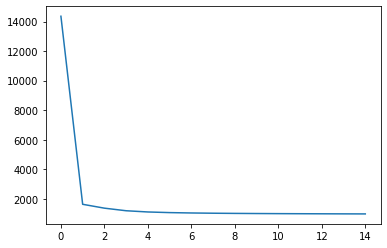

In [300]:
plt.plot(model_artm.score_tracker["PerplexityScore"].value)

In [303]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-100))

In [304]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

#### Проделаем те же шаги, что и для случая с одной модальностью(текст) и выведем результат

In [305]:
for topic_name in model_artm.topic_names:
    print (topic_name + ': ',)
    print (model_artm.score_tracker['TopTokensScore'].last_tokens[topic_name])

topic_0: 
['learn', 'use', 'method', 'function', 'show', 'propose', 'data', 'set', 'result', 'approach']
topic_1: 
['information', 'representation', 'visual', 'image', 'structure', 'pattern', 'map', 'object', 'field', 'represent']
topic_2: 
['model', 'system', 'neural', 'process', 'use', 'train', 'spike', 'state', 'behavior', 'make']
topic_3: 
['word', 'language', 'semantic', 'context', 'information', 'base', 'natural', 'knowledge', 'method', 'evaluation']
topic_4: 
['question', 'answer']
topic_5: 
['neuron', 'model', 'input', 'network', 'show', 'spike', 'synaptic', 'activity', 'stimulus', 'response']
topic_6: 
['measure', 'source', 'pronunciation']
topic_7: 
['system', 'use', 'analysis', 'paper', 'information', 'approach', 'present', 'corpus', 'application', 'text']
topic_8: 
['feature', 'task', 'model', 'data', 'method', 'work', 'label', 'learn', 'document', 'stateoftheart']
topic_9: 
['speech', 'recognition', 'system', 'use', 'speaker', 'feature', 'performance', 'base', 'acoustic', 

In [306]:
print (model_artm.score_tracker["SparsityPhiScore"].last_value)
print (model_artm.score_tracker["SparsityThetaScore"].last_value)
print (model_artm.score_tracker["PerplexityScore"].last_value)

0.9984301328659058
0.6638703346252441
103.46533966064453


# ИЕРАРХИЧЕСКИЙ TOPIC MODELLING(используем batch с модальностью текст)

In [311]:
batch_vectorizer = artm.BatchVectorizer(data_path='final_vw_data',
                                        data_format='batches')
dictionary = artm.Dictionary()
dictionary.gather(batch_vectorizer.data_path)

#### Cоздадим основную модель для иерархии

In [308]:
hier = artm.hARTM()

#### Уровни в иерархии строются постепенно, создадим объект нулевого уровня

In [309]:
level0 = hier.add_level(num_topics=10)
level0.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=20, 
                                      class_id='text'))

In [312]:
level0.initialize(dictionary=dictionary)
level0.fit_offline(batch_vectorizer, num_collection_passes=30)

In [314]:
for topic_name in level0.topic_names:
    print (topic_name + ': ',)
    print (", ".join(level0.score_tracker['TopTokensScore'].last_tokens[topic_name]))

topic_0: 
model, system, control, visual, use, image, dynamic, brain, task, motion, signal, result, movement, study, different, learn, data, change, motor, time
topic_1: 
neuron, model, spike, input, synaptic, stimulus, cell, fire, activity, response, show, rate, time, population, neural, information, neuronal, cortical, mechanism, network
topic_2: 
parse, representation, structure, semantic, tree, use, information, feature, grammar, relation, approach, dependency, parser, show, question, object, task, syntactic, sentence, similarity
topic_3: 
system, speech, use, dialogue, human, user, paper, feature, spoken, information, show, utterance, present, result, interaction, generation, synthesis, evaluation, task, model
topic_4: 
algorithm, function, learn, problem, show, error, result, use, method, kernel, linear, parameter, set, case, approximation, bound, number, optimal, generalization, derive
topic_5: 
model, data, method, use, propose, approach, cluster, learn, estimate, set, paramete

#### И только после этого создадим следующий уровень

In [315]:
level1 = hier.add_level(num_topics=20, topic_names=['внутренний_топик_' + str(i) for i in range(20)], 
                        parent_level_weight=1)

In [316]:
level1.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=20, 
                                      class_id='text'))

In [317]:
level1.initialize(dictionary=dictionary)
level1.fit_offline(batch_vectorizer, num_collection_passes=30)

In [318]:
psi = level1.get_psi()

In [319]:
psi

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
внутренний_топик_0,0.007193,0.260739,0.000124,0.000090,0.000053,0.000070,0.000052,0.000263,0.000043,0.000024
внутренний_топик_1,0.000109,0.000014,0.014589,0.002179,0.000090,0.000405,0.078190,0.000069,0.000580,0.280796
внутренний_топик_2,0.000367,0.355991,0.000045,0.000072,0.000424,0.000084,0.000018,0.000285,0.000224,0.000077
внутренний_топик_3,0.004083,0.002320,0.002474,0.198137,0.000262,0.000536,0.001490,0.000096,0.000640,0.002078
внутренний_топик_4,0.000444,0.003384,0.000213,0.000084,0.367667,0.002032,0.000078,0.001097,0.001255,0.000449
внутренний_топик_5,0.000602,0.000841,0.001097,0.000425,0.006696,0.001268,0.000208,0.270400,0.000140,0.001027
внутренний_топик_6,0.977961,0.001597,0.000303,0.000543,0.000085,0.000126,0.000077,0.000230,0.000121,0.000061
внутренний_топик_7,0.000145,0.000105,0.000052,0.001274,0.000051,0.000045,0.000025,0.000047,0.634975,0.000419
внутренний_топик_8,0.000486,0.003561,0.000017,0.000010,0.000112,0.000141,0.000008,0.407173,0.000014,0.000007
внутренний_топик_9,0.000824,0.000142,0.004327,0.002632,0.002120,0.008828,0.001659,0.001007,0.281097,0.015477


In [320]:
for topic_name in level1.topic_names:
    print(topic_name + ': ')
    print(" ".join(level1.score_tracker['TopTokensScore'].last_tokens[topic_name]))

внутренний_топик_0: 
model pattern cortical field cortex cell activity visual show phase temporal neuron mechanism receptive property oscillation map orientation input couple
внутренний_топик_1: 
corpus language use word method text task sentence approach data different document result information system phrase propose english tag two
внутренний_топик_2: 
spike neuron synaptic model time input rate correlation train fire process information noise plasticity synapsis neural simulation dynamic stochastic interval
внутренний_топик_3: 
model human decision expression prediction metric task predict information generation make cue duration group study description factor performance show use
внутренний_топик_4: 
function distribution approximation show parameter probability estimate estimator use number density n result information derive measure sample error method case
внутренний_топик_5: 
learn input rule weight unit output pattern training use layer hidden algorithm local show sequence re

#### Попробуем регуляризацию

In [321]:
level1.regularizers.add(artm.HierarchySparsingThetaRegularizer(name="HierSp", tau=1.0))

In [322]:
level1.initialize(dictionary=dictionary)
level1.fit_offline(batch_vectorizer, num_collection_passes=30)

In [323]:
for topic_name in level1.topic_names:
    print(topic_name + ': ')
    print(" ".join(level1.score_tracker['TopTokensScore'].last_tokens[topic_name]))

внутренний_топик_0: 
model pattern cortical field cortex cell activity visual show phase temporal neuron mechanism receptive property oscillation map orientation input couple
внутренний_топик_1: 
corpus language use word method text task sentence approach data different document result information system phrase propose english two tag
внутренний_топик_2: 
spike neuron synaptic model time input rate correlation train fire process information noise plasticity synapsis neural simulation dynamic stochastic interval
внутренний_топик_3: 
model human decision expression prediction metric task predict information generation make cue duration group study description factor performance show use
внутренний_топик_4: 
function distribution approximation show parameter probability estimate estimator use number density n result information derive measure sample error method case
внутренний_топик_5: 
learn input rule weight unit output pattern training use layer hidden algorithm local show sequence re

#### Посчитаем две метрики в иерархии

#### support - Обычно необходимо установить пороговое значение psi, равное минимальному значению p (t | a) , чтобы ссылка a-t была включена в тематический граф. Но с высоким порогом у некоторых тем не будет родителей. Определяют support как максимальный доступный порог для матрицы Psi, с которой все темы будут иметь хотя бы одного предка.

In [324]:
psi = level1.get_psi()
print ("Psi support:", psi.values.max(axis=1).min())

Psi support: 0.07614362


#### Среднее количество родителей(mean parents count). В BigARTM иерархия определяется как многоуровневый тематический граф, который отличается от тематического дерева. Поэтому разумно оценить среднее количество родителей.

In [327]:
psi_threshold = 0.01
parent_counts = np.zeros(0)
for level_idx in range(1, hier.num_levels):
    psi = hier.get_level(level_idx).get_psi().values
    parent_counts = np.hstack((parent_counts, (psi > psi_threshold).sum(axis=1)))
print ("Mean parents count:", parent_counts.mean())

Mean parents count: 1.25


### Построим наконец связи между уровнями 

In [329]:
batch = artm.messages.Batch()
batch_name = 'phi1.batch'

with open(batch_name, "rb") as f:
    batch.ParseFromString(f.read())
    
Ntw = np.zeros(len(level0.topic_names))
    
for i,item in enumerate(batch.item):
    for (token_id, token_weight) in zip(item.field[0].token_id, item.field[0].token_weight):
        Ntw[i] += token_weight

Nt1t0 = np.array(psi) * Ntw
psi_bayes = (Nt1t0 / Nt1t0.sum(axis=1)[:, np.newaxis]).T

In [330]:
indexes_child = np.argmax(psi_bayes, axis=0)

#### Покажем к примеру для топика номер 6

In [77]:
topic_parent_name = 'topic_6'
print(topic_parent_name + ':')
print(" ".join(level0.score_tracker['TopTokensScore'].last_tokens[topic_parent_name]))
print('')

for child in np.where(indexes_child == 6)[0]:
    print('    ' + level1.topic_names[child] + ': ')
    print(" ".join(level1.score_tracker['TopTokensScore'].last_tokens[level1.topic_names[child]]))
    print('')

topic_6:


NameError: name 'level0' is not defined